### Cifar10 dataset loader


In [100]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


def get_loaders(
    source, batch_size, transform, eval_transform=None, root="data", split_ratio=0.1
):
    if eval_transform is None:
        eval_transform = transform

    trainset = source(
        root=root,
        train=True,
        download=True,
        transform=transform,
    )
    testset = source(
        root=root,
        train=False,
        download=True,
        transform=eval_transform,
    )

    trainset, valset = torch.utils.data.random_split(
        trainset,
        [int((1 - split_ratio) * len(trainset)), int(split_ratio * len(trainset))],
    )

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(valset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    return trainloader, valloader, testloader


def get_cifar10_loaders(batch_size, root="data/cifar10", split_ratio=0.1):
    transform = transforms.Compose(
        [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(
                brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        ]
    )
    eval_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        ]
    )
    return get_loaders(
        datasets.CIFAR10,
        batch_size,
        transform,
        eval_transform=eval_transform,
        root=root,
        split_ratio=split_ratio,
    )


DATALOADERS = {
    "cifar10": get_cifar10_loaders,
}

if __name__ == "__main__":
    datasets_to_load = ["cifar10"]
    for dataset in datasets_to_load:
        trainloader, valloader, testloader = DATALOADERS[dataset](batch_size=64)
        print(f'{dataset}: {len(trainloader.dataset)}, {len(valloader.dataset)}, {len(testloader.dataset)}, {trainloader.dataset[0][0].shape}')

Files already downloaded and verified
Files already downloaded and verified
cifar10: 45000, 5000, 10000, torch.Size([3, 32, 32])


#### Useful utilities
- ``evaluate(model, loader, criterion, device)`` – Evaluates a model on a dataset, computing loss, accuracy, and confusion matrix.
- ``plot_loss_accuracy(train_loss, train_acc, val_loss, val_acc, filename)`` – Plots and saves the training and validation loss/accuracy curves.
- ``save_model(model, filename, verbose, existed)`` – Saves a PyTorch model's state dictionary while handling filename conflicts.
- ``load_model(model, filename, qconfig, fuse_modules, verbose)`` – Loads a saved model, optionally applying quantization and module fusion.
- ``reset_seed(seed)`` – Sets seeds for PyTorch and NumPy to ensure reproducibility.
- ``plot_confusion_matrix(conf_matrix, filename)`` – Generates and saves a heatmap of the confusion matrix for CIFAR-10 classification.



In [ ]:
import os

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import torch
import torch.ao.quantization as tq
from tqdm.notebook import tqdm

DEFAULT_DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


def evaluate(model, loader, criterion, device=DEFAULT_DEVICE):
    running_loss = 0
    total, correct = 0, 0
    all_preds, all_labels = [], []

    model.eval()
    with torch.no_grad():
        loop = tqdm(loader, desc="Evaluating", leave=True)

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)

            running_loss += loss.item()
            predicted = torch.argmax(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        loop.set_postfix(
            loss=running_loss / (total / images.shape[0]), accuracy=correct / total
        )

    avg_loss = running_loss / len(loader)
    accuracy = correct / total
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return avg_loss, accuracy, conf_matrix


def preprocess_filename(filename: str, existed: str = "keep_both") -> str:
    if existed == "overwrite":
        pass
    elif existed == "keep_both":
        base, ext = os.path.splitext(filename)
        cnt = 1
        while os.path.exists(filename):
            filename = f"{base}-{cnt}{ext}"
            cnt += 1
    elif existed == "raise" and os.path.exists(filename):
        raise FileExistsError(f"{filename} already exists.")
    else:
        raise ValueError(f"Unknown value for 'existed': {existed}")
    return filename


def plot_loss_accuracy(
    train_loss, train_acc, val_loss, val_acc, filename="loss_accuracy.png"
):

    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.plot(train_loss, color="tab:blue")
    ax1.plot(val_loss, color="tab:red")
    ax1.legend(["Training", "Validation"])
    ax1.set_title("Loss")

    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.plot(train_acc, color="tab:blue")
    ax2.plot(val_acc, color="tab:red")
    ax2.legend(["Training", "Validation"])
    ax2.set_title("Accuracy")

    fig.tight_layout()
    filename = preprocess_filename(filename)
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    plt.savefig(filename)
    print(f"Plot saved at {filename}")


def plot_confusion_matrix(conf_matrix, filename="conf_matrix.png"):
    classes = [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ]
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=classes,
        yticklabels=classes,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix for CIFAR-10 Classification")
    plt.tight_layout()

    filename = preprocess_filename(filename)
    plt.savefig(filename)
    print(f"Confusion matrix saved to {filename}")


def save_model(
    model, filename: str, verbose: bool = True, existed: str = "keep_both"
) -> None:
    filename = preprocess_filename(filename, existed)

    os.makedirs(os.path.dirname(filename), exist_ok=True)
    torch.save(model.state_dict(), filename)
    if verbose:
        print(f"Model saved at {filename} ({os.path.getsize(filename) / 1e6} MB)")
    else:
        print(f"Model saved at {filename}")

def load_model(
    model, filename: str, qconfig=None, fuse_modules: bool = False, verbose: bool = True
) -> torch.nn.Module:

    if fuse_modules and hasattr(model, "fuse_modules"):
        print("Fusing modules")
        model.fuse_modules()
    else:
        print("Model does not have 'fuse_modules' method. Skipping fusion.")

    if qconfig is not None:
        model = tq.QuantWrapper(model)
        model.qconfig = qconfig
        tq.prepare(model, inplace=True)
        tq.convert(model, inplace=True)

    device = DEFAULT_DEVICE if qconfig is None else "cpu"
    model.load_state_dict(torch.load(filename, map_location=device))

    if verbose:
        print(
            f"Model loaded from {filename} ({os.path.getsize(filename) / 1e6} MB)")
    return model


def reset_seed(seed: int = 42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### VGG

#### Implement your model based on the given model architecture in the lab material.



In [102]:
import torch
import torch.nn as nn
import torch.ao.quantization as tq


class VGG(nn.Module):
    """ Implement your model here """
    def __init__(self, in_channels=3, in_size=32, num_classes=10) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv2
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(192)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv3
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(384)
        self.relu3 = nn.ReLU(inplace=True)

        # Conv4
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU(inplace=True)

        # Conv5
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.relu5 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 計算 feature map 的大小
        fmap_size = in_size // 2 // 2 // 2  # 3 次 MaxPool，大小變 1/8
        self.fc6 = nn.Linear(256 * fmap_size * fmap_size, 256)
        self.fc7 = nn.Linear(256, 128)
        self.fc8 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.4)
        
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.relu4(self.bn4(self.conv4(x)))
        x = self.relu5(self.bn5(self.conv5(x)))
        x = self.pool5(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc6(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc7(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc8(x)
        return x

    def fuse_modules(self):
        try:
            self.eval()
            
            tq.fuse_modules(self, [['conv1', 'bn1', 'relu1'],
                                ['conv2', 'bn2', 'relu2'],
                                ['conv3', 'bn3', 'relu3'],
                                ['conv4', 'bn4', 'relu4'],
                                ['conv5', 'bn5', 'relu5']], inplace=True)
            
            print("✅ Modules successfully fused.")
        except Exception as e:
            print(f"⚠️ Fuse failed: {e}")
    

if __name__ == "__main__":
    model = VGG()
    inputs = torch.randn(1, 3, 32, 32)
    print(model)

    from torchsummary import summary

    summary(model, (3, 32, 32), device="cpu")

VGG(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU(inplace=True)
  (conv5): Conv2d(256, 256, kern

### QConfig
#### Quantization scheme
- Write your QConfig Observer inorder to do PTQ
- Use Power-of-Two uniform/scale, symmetric quantization to quantize model.
- Finish qconfig observer for PTQ calibration.


In [ ]:
from enum import Enum
import math
from icecream import ic
import torch
import torch.ao.quantization as tq


class PowerOfTwoObserver(tq.MinMaxObserver):
    """
    Observer module for power-of-two quantization (dyadic quantization with b = 1).
    """

    def scale_approximate(self, scale: float, max_shift_amount=8) -> float:
        if scale == 0:
            return 0  # 直接返回 0，而不是一個很小的值
        if scale < 0:
            print("⚠️ Warning: scale is negative! Using absolute value.")
            scale = abs(scale)
            return 1.0
        log2_scale = round(math.log2(scale)) 
        log2_scale = max(-max_shift_amount, min(log2_scale, max_shift_amount))
        return 2 ** log2_scale

    def calculate_qparams(self):
        """Calculates the quantization parameters with scale as power of two."""
        min_val, max_val = self.min_val.item(), self.max_val.item()

        """ Calculate zero_point as in the base class """
        #########Implement your code here##########
    
        # 處理極端值
        if math.isinf(min_val) or math.isinf(max_val):
            min_val = -1 if math.isinf(min_val) else min_val
            max_val = 1 if math.isinf(max_val) else max_val

        # 避免 min 和 max 相等（通常是全 0 的情況）
        if min_val == max_val:
            min_val, max_val = min_val - 1, max_val + 1

        # 計算尺度 (scale)
        scale = (max_val - min_val) / 255  # 8-bit 範圍

        # 計算 zero_point (對稱量化固定為 0)
        if self.dtype == torch.quint8:
            zero_point = 128
        elif self.dtype == torch.qint8:
            zero_point = 0
        else:
            # Default case
            zero_point = 0
        ##########################################
        scale = self.scale_approximate(scale)
        scale = torch.tensor(scale, dtype=torch.float32)
        zero_point = torch.tensor(zero_point, dtype=torch.int64)
        return scale, zero_point

    def extra_repr(self):
        return f"min_val={self.min_val}, max_val={self.max_val}, scale=PowerOfTwo"


class CustomQConfig(Enum):
    POWER2 = tq.QConfig(
        activation=PowerOfTwoObserver.with_args(
            dtype=torch.quint8, qscheme=torch.per_tensor_symmetric
        ),
        weight=PowerOfTwoObserver.with_args(
            dtype=torch.qint8, qscheme=torch.per_tensor_symmetric
        ),
    )
    DEFAULT = None

### Model Training

- Set hyper parameter for training.
- Record the number of epochs and the accuracy in the results.
- Plot the accuracy and loss.



Files already downloaded and verified
Files already downloaded and verified


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  1/50  lr=1.00e-02, train_loss=1.7621, val_loss=1.5539, train_acc=0.3358, val_acc=0.4278
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  2/50  lr=9.99e-03, train_loss=1.4748, val_loss=1.4184, train_acc=0.4655, val_acc=0.4850
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  3/50  lr=9.96e-03, train_loss=1.3289, val_loss=1.3205, train_acc=0.5284, val_acc=0.5252
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  4/50  lr=9.91e-03, train_loss=1.2186, val_loss=1.1680, train_acc=0.5733, val_acc=0.5802
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  5/50  lr=9.84e-03, train_loss=1.1344, val_loss=1.1416, train_acc=0.6067, val_acc=0.5936
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  6/50  lr=9.76e-03, train_loss=1.0605, val_loss=1.0428, train_acc=0.6365, val_acc=0.6198
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  7/50  lr=9.65e-03, train_loss=1.0003, val_loss=0.9888, train_acc=0.6580, val_acc=0.6502
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  8/50  lr=9.52e-03, train_loss=0.9469, val_loss=1.0066, train_acc=0.6795, val_acc=0.6526
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  9/50  lr=9.38e-03, train_loss=0.8997, val_loss=0.8924, train_acc=0.6981, val_acc=0.6826
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/50  lr=9.22e-03, train_loss=0.8565, val_loss=0.8437, train_acc=0.7158, val_acc=0.7080
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11/50  lr=9.05e-03, train_loss=0.8224, val_loss=0.8158, train_acc=0.7282, val_acc=0.7202
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12/50  lr=8.85e-03, train_loss=0.7866, val_loss=0.7389, train_acc=0.7396, val_acc=0.7476
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13/50  lr=8.64e-03, train_loss=0.7468, val_loss=0.7415, train_acc=0.7502, val_acc=0.7510
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14/50  lr=8.42e-03, train_loss=0.7208, val_loss=0.7261, train_acc=0.7628, val_acc=0.7504


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15/50  lr=8.19e-03, train_loss=0.6815, val_loss=0.6777, train_acc=0.7737, val_acc=0.7656
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16/50  lr=7.94e-03, train_loss=0.6598, val_loss=0.6987, train_acc=0.7800, val_acc=0.7666
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17/50  lr=7.68e-03, train_loss=0.6340, val_loss=0.6572, train_acc=0.7922, val_acc=0.7838
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18/50  lr=7.41e-03, train_loss=0.6065, val_loss=0.6694, train_acc=0.8016, val_acc=0.7722


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19/50  lr=7.13e-03, train_loss=0.5912, val_loss=0.6229, train_acc=0.8050, val_acc=0.7888
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20/50  lr=6.84e-03, train_loss=0.5633, val_loss=0.5876, train_acc=0.8160, val_acc=0.8014
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21/50  lr=6.55e-03, train_loss=0.5452, val_loss=0.6339, train_acc=0.8182, val_acc=0.7908


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22/50  lr=6.24e-03, train_loss=0.5268, val_loss=0.5643, train_acc=0.8277, val_acc=0.8022
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23/50  lr=5.94e-03, train_loss=0.5062, val_loss=0.5836, train_acc=0.8329, val_acc=0.7958


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24/50  lr=5.63e-03, train_loss=0.4854, val_loss=0.5771, train_acc=0.8374, val_acc=0.8056
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25/50  lr=5.31e-03, train_loss=0.4728, val_loss=0.5566, train_acc=0.8459, val_acc=0.8166
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26/50  lr=5.00e-03, train_loss=0.4637, val_loss=0.5568, train_acc=0.8477, val_acc=0.8144


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27/50  lr=4.69e-03, train_loss=0.4450, val_loss=0.5544, train_acc=0.8557, val_acc=0.8170
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28/50  lr=4.37e-03, train_loss=0.4295, val_loss=0.5117, train_acc=0.8596, val_acc=0.8284
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29/50  lr=4.06e-03, train_loss=0.4073, val_loss=0.5068, train_acc=0.8648, val_acc=0.8274


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30/50  lr=3.76e-03, train_loss=0.3927, val_loss=0.5178, train_acc=0.8692, val_acc=0.8290
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 31/50  lr=3.46e-03, train_loss=0.3771, val_loss=0.5124, train_acc=0.8759, val_acc=0.8326
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 32/50  lr=3.16e-03, train_loss=0.3639, val_loss=0.4883, train_acc=0.8810, val_acc=0.8396
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 33/50  lr=2.87e-03, train_loss=0.3545, val_loss=0.4876, train_acc=0.8842, val_acc=0.8426
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 34/50  lr=2.59e-03, train_loss=0.3351, val_loss=0.4875, train_acc=0.8890, val_acc=0.8418


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 35/50  lr=2.32e-03, train_loss=0.3286, val_loss=0.4817, train_acc=0.8913, val_acc=0.8472
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 36/50  lr=2.06e-03, train_loss=0.3198, val_loss=0.4817, train_acc=0.8945, val_acc=0.8488
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 37/50  lr=1.81e-03, train_loss=0.3093, val_loss=0.4422, train_acc=0.8970, val_acc=0.8520
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 38/50  lr=1.58e-03, train_loss=0.2974, val_loss=0.4408, train_acc=0.9015, val_acc=0.8570
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 39/50  lr=1.36e-03, train_loss=0.2848, val_loss=0.4565, train_acc=0.9064, val_acc=0.8570
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 40/50  lr=1.15e-03, train_loss=0.2733, val_loss=0.4621, train_acc=0.9110, val_acc=0.8478


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 41/50  lr=9.56e-04, train_loss=0.2681, val_loss=0.4548, train_acc=0.9112, val_acc=0.8568


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 42/50  lr=7.79e-04, train_loss=0.2558, val_loss=0.4332, train_acc=0.9161, val_acc=0.8562


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 43/50  lr=6.19e-04, train_loss=0.2447, val_loss=0.4525, train_acc=0.9207, val_acc=0.8620
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 44/50  lr=4.77e-04, train_loss=0.2436, val_loss=0.4488, train_acc=0.9205, val_acc=0.8604


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 45/50  lr=3.52e-04, train_loss=0.2354, val_loss=0.4561, train_acc=0.9231, val_acc=0.8560


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 46/50  lr=2.46e-04, train_loss=0.2360, val_loss=0.4226, train_acc=0.9240, val_acc=0.8668
Model saved at weights/cifar10/vgg.pt (13.367527 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 47/50  lr=1.58e-04, train_loss=0.2303, val_loss=0.4334, train_acc=0.9246, val_acc=0.8626


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 48/50  lr=8.96e-05, train_loss=0.2289, val_loss=0.4426, train_acc=0.9241, val_acc=0.8654


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 49/50  lr=4.04e-05, train_loss=0.2245, val_loss=0.4314, train_acc=0.9265, val_acc=0.8644


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 50/50  lr=1.09e-05, train_loss=0.2253, val_loss=0.4442, train_acc=0.9264, val_acc=0.8638


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test: loss=0.3493, accuracy=0.8970
Model size: 13.37 MB
Plot saved at figure/cifar10/vgg.png
Time: 1721.29s


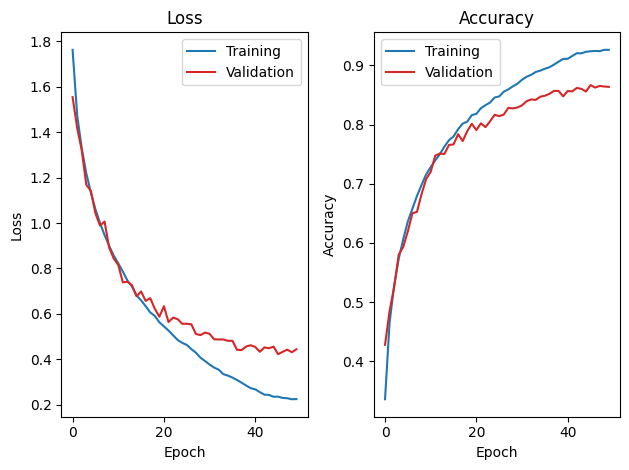

In [104]:
import os
import time

import torch
from torch import nn, optim
from tqdm.auto import tqdm

reset_seed(10)


def train_one_epoch(model, loader, criterion, optimizer, device=DEFAULT_DEVICE):
    running_loss = 0
    total, correct = 0, 0

    loop = tqdm(loader, desc="Training", leave=True)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = torch.argmax(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix(
            loss=running_loss / (total / images.shape[0]), accuracy=correct / total
        )

    avg_loss = running_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy


def train(
    model,
    trainloader,
    valloader,
    criterion,
    optimizer,
    scheduler=None,
    epochs=1,
    save_path=None,
    device=DEFAULT_DEVICE,
):
    model = model.to(device)

    train_loss, train_acc = [], []
    val_loss, val_acc = [], []

    epoch_loop = tqdm(range(epochs), desc="Epochs", leave=True)

    for epoch in epoch_loop:
        model.train()
        _train_loss, _train_acc = train_one_epoch(
            model, trainloader, criterion, optimizer
        )
        train_loss.append(_train_loss)
        train_acc.append(_train_acc)

        model.eval()
        _val_loss, _val_acc, _ = evaluate(model, valloader, criterion)
        val_loss.append(_val_loss)
        val_acc.append(_val_acc)

        print(f"Epoch {epoch + 1:2d}/{epochs}", end="  ")
        if scheduler is not None:
            print(f"lr={scheduler.get_last_lr()[0]:.2e}", end=", ")
        print(f"train_loss={_train_loss:.4f}, val_loss={_val_loss:.4f}", end=", ")
        print(f"train_acc={_train_acc:.4f}, val_acc={_val_acc:.4f}")

        if _val_acc >= max(val_acc):
            save_model(model, save_path, existed="overwrite")

        if scheduler is not None:
            scheduler.step()

        epoch_loop.set_postfix(
            train_loss=_train_loss,
            val_loss=_val_loss,
            train_acc=_train_acc,
            val_acc=_val_acc,
        )

    return train_loss, train_acc, val_loss, val_acc


def main(epochs, network, dataset, name=None):
    dataset = dataset.lower()
    if name is None:
        name = f"{dataset}/{network.__name__.lower()}"

    t = time.time()
    trainloader, valloader, testloader = DATALOADERS[dataset](batch_size=64)
    in_channels, in_size = trainloader.dataset[0][0].shape[:2]
    model = network(in_channels, in_size).to(DEFAULT_DEVICE)
    #########Implement your code here##########
    # Loss function
    criterion = nn.CrossEntropyLoss()
    #Optimizer
    optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9,weight_decay=1e-4)
    #Scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)
    ##########################################
    train_loss, train_acc, val_loss, val_acc = train(
        model,
        trainloader,
        valloader,
        criterion,
        optimizer,
        scheduler,
        epochs,
        save_path=f"weights/{name}.pt",
    )

    test_loss, test_accuracy, _ = evaluate(model.eval(), testloader, criterion)
    print(f"Test: loss={test_loss:.4f}, accuracy={test_accuracy:.4f}")
    print(f"Model size: {os.path.getsize(f'weights/{name}.pt') / 1e6:.2f} MB")

    plot_loss_accuracy(train_loss, train_acc, val_loss, val_acc, f"figure/{name}.png")
    print(f"Time: {time.time() - t:.2f}s")


if __name__ == "__main__":
    for network in [VGG]:
        """ You can adjust the number of epochs """
        EPOCHS = 50
        main(epochs=EPOCHS, network=network, dataset="cifar10")

### PTQ on VGG Model

#### You can refer to 'Quantization in Practice' in the lab material.



In [107]:
import os
import torch
import torchvision
from torch import nn, optim
import torch.ao.quantization as tq

reset_seed(0)

#########Implement your code here##########
""" Calibrate Method """
def calibrate(model, loader, device=DEFAULT_DEVICE, num_batches=50):
    model.eval()
    model.to(device)
    
    with torch.no_grad():
        for i, (images, _) in enumerate(tqdm(loader, desc="Calibrating Model")):
            images = images.to(device)
            model(images)  # 讓 Observer 收集 activation 範圍
            if num_batches is not None and i >= num_batches - 1:
                break  # 使用指定數量的批次
    print("✅ Calibration complete.")
###########################################

def main(network, verbose=True):

    #########Implement your code here##########
    
    *_, test_loader = DATALOADERS[dataset](batch_size=1000)
    in_channels, in_size = test_loader.dataset[0][0].shape[:2]

    
    model = network(in_channels, in_size).eval().cpu()
    model.load_state_dict(torch.load("./weights/cifar10/vgg.pt"))
    model = tq.QuantWrapper(model)
    model.qconfig = CustomQConfig.POWER2.value
    
    #fuse_modules(model.module)
    model.module.fuse_modules()
    tq.prepare(model, inplace=True)
    
    calibrate(model, test_loader, "cpu")
    
    tq.convert(model.cpu(), inplace=True)
    save_model(model, "weights/cifar10/vgg-power2.pt",
                verbose=True,existed="overwrite")

    if verbose:
        print("Quantized model saved at vgg-power2.pt")
    ###########################################


if __name__ == "__main__":
    main(network=VGG, verbose=True) 

Files already downloaded and verified
Files already downloaded and verified
✅ Modules successfully fused.


C:\Users\bend0\AppData\Local\Temp\ipykernel_12312\1959724836.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./weights/cifar10/vgg.pt"

Calibrating Model:   0%|          | 0/10 [00:00<?, ?it/s]

✅ Calibration complete.
Model saved at weights/cifar10/vgg-power2.pt (3.350946 MB)
Quantized model saved at vgg-power2.pt


### Evaluate Quantized Model


In [108]:
import os
from torch import nn
import torch.ao.quantization as tq

reset_seed(0)


def main():
    dataset = 'cifar10'
    backend = 'power2'
    model_path = './weights/cifar10/vgg-power2.pt'
    

    *_, test_loader = DATALOADERS[dataset](batch_size=1000)
    in_channels, in_size = test_loader.dataset[0][0].shape[:2]
    
    if backend:
        qconfig = CustomQConfig[backend.upper()].value
        fuse_modules = True
    else:
        qconfig = None
        fuse_modules = False
        
    model = load_model(VGG(in_channels, in_size), model_path,
                       qconfig=qconfig, fuse_modules=fuse_modules)
    print(model)



    device = "cpu" if backend else DEFAULT_DEVICE
    criterion = nn.CrossEntropyLoss()
    test_loss, test_accuracy, _ = evaluate(
        model.to(device), test_loader, criterion, device=device
    )
    print(
        f"Test: loss={test_loss:.4f}, accuracy={test_accuracy:.4f}, size={os.path.getsize(model_path) / 1e6}MB"
    )

torch.Size([1000, 3, 32, 32])

if __name__ == "__main__":
    main()

Files already downloaded and verified
Files already downloaded and verified
Fusing modules
✅ Modules successfully fused.
Model loaded from ./weights/cifar10/vgg-power2.pt (3.350946 MB)
QuantWrapper(
  (quant): Quantize(scale=tensor([0.0156]), zero_point=tensor([128]), dtype=torch.quint8)
  (dequant): DeQuantize()
  (module): VGG(
    (conv1): QuantizedConvReLU2d(3, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.0625, zero_point=128, padding=(1, 1))
    (bn1): Identity()
    (relu1): Identity()
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): QuantizedConvReLU2d(64, 192, kernel_size=(3, 3), stride=(1, 1), scale=0.0625, zero_point=128, padding=(1, 1))
    (bn2): Identity()
    (relu2): Identity()
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): QuantizedConvReLU2d(192, 384, kernel_size=(3, 3), stride=(1, 1), scale=0.03125, zero_point=128, padding=(1, 1))
    (bn3): Identity()
    (relu

C:\Users\bend0\AppData\Local\Temp\ipykernel_12312\3816497647.py:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename, map_location=de

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Test: loss=0.3592, accuracy=0.8953, size=3.350946MB
